In [1]:
using Flux, Statistics
using Flux.Data: DataLoader
using Flux: onehotbatch, onecold, @epochs
using Flux.Losses: logitcrossentropy
using Base: @kwdef
using MLDatasets
using Plots

In [2]:
include("network.jl")
include("vsa.jl")
include("spiking.jl")

train_to_phase (generic function with 2 methods)

In [3]:
function getdata(args)
    ENV["DATADEPS_ALWAYS_ACCEPT"] = "true"

    @info "Getting and transforming data"

    ## Load dataset
    xtrain, ytrain = MLDatasets.MNIST(:train)[:]
    xtest, ytest = MLDatasets.MNIST(:test)[:]

    ## Reshape input data to flatten each image into a linear array
    xtrain = Flux.flatten(xtrain)
    xtest = Flux.flatten(xtest)

    ## One-hot-encode the labels
    ytrain, ytest = onehotbatch(ytrain, 0:9), onehotbatch(ytest, 0:9)

    ## Create two DataLoader objects (mini-batch iterators)
    train_loader = DataLoader((xtrain, ytrain), batchsize=args.batchsize, shuffle=true)
    test_loader = DataLoader((xtest, ytest), batchsize=args.batchsize)

    return train_loader, test_loader
end

getdata (generic function with 1 method)

In [4]:
function build_model(; imgsize=(28,28,1), nclasses=10)
    return Chain( PhasorDense(prod(imgsize) => 32),
                  PhasorDense(32 => nclasses))
end

build_model (generic function with 1 method)

In [5]:
@kwdef mutable struct Args
    η::Float64 = 3e-4       ## learning rate
    batchsize::Int = 256    ## batch size
    epochs::Int = 10        ## number of epochs
    use_cuda::Bool = false   ## use gpu (if cuda available)
end

Args

In [6]:
train_loader, test_loader = getdata(Args())

[ Info: Getting and transforming data


(DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, shuffle=true, batchsize=256), DataLoader(::Tuple{Matrix{Float32}, OneHotArrays.OneHotMatrix{UInt32, Vector{UInt32}}}, batchsize=256))

In [7]:
x, y = first(train_loader)

(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Bool[0 0 … 0 0; 0 0 … 0 0; … ; 0 0 … 0 0; 0 1 … 1 1])

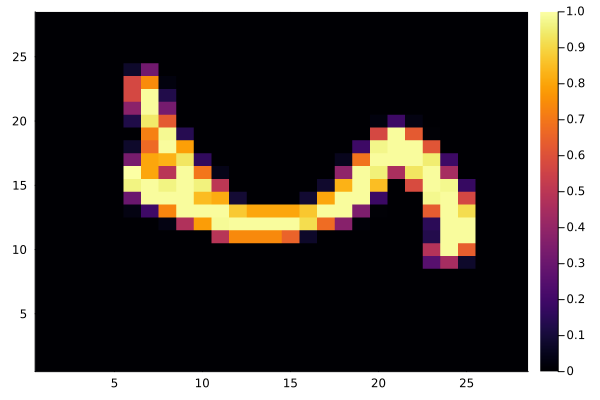

In [8]:
heatmap(reshape(x'[1,:], (28, 28)))

In [9]:
y

10×256 OneHotMatrix(::Vector{UInt32}) with eltype Bool:
 ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  …  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅     ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  1  ⋅  ⋅     ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅
 ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1     1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  ⋅  ⋅  ⋅  ⋅
 ⋅  1  ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅     ⋅  1  ⋅  1  ⋅  ⋅  ⋅  ⋅  ⋅  ⋅  1  1

In [10]:
phasor_model = build_model()

Chain(
  PhasorDense(784 => 32),               # 25_120 parameters
  PhasorDense(32 => 10),                # 330 parameters
)                   # Total: 4 arrays, 25_450 parameters, 199.078 KiB.

In [11]:
pc = phasor_model(x')

256×10 Matrix{Float32}:
 -0.489886   -0.0142348    …   0.97836    0.40999     0.037495
 -0.267291    0.0636112        0.966731   0.690894    0.0254125
  0.762533    0.104524        -0.851758  -0.0383527   0.0650418
  0.203458    0.0232392        0.868048   0.70802     0.0707891
  0.838      -0.0817891        0.730179  -0.848982    0.0604818
  0.114579    0.0263506    …   0.976981   0.212646    0.0421572
  0.0906201  -0.00221237       0.877613  -0.857572    0.00438325
 -0.314387   -0.0276644        0.819453   0.31326     0.104664
  0.919195   -0.0972405       -0.959182  -0.119974    0.0695042
 -0.270485   -0.0139232        0.944435   0.480331    0.0214323
 -0.135377   -0.0757059    …   0.878676  -0.317743    0.0778406
  0.380735    0.0111415        0.965708  -0.101097   -0.0528629
  0.387825    0.000227693     -0.95982   -0.519203    0.074146
  ⋮                        ⋱                         
 -0.180824    0.024276        -0.768756   0.255651    0.110272
  0.668982    0.0286398    … 

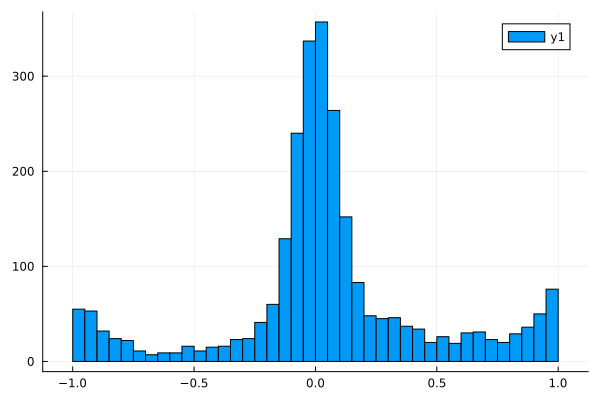

In [12]:
histogram(pc |> vec)

In [13]:
sa = default_spk_args()

Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)


In [14]:
xt = phase_to_train(x', sa, repeats = 3)

Spike Train: (256, 784) with 602112 spikes.

In [15]:
xt.shape

(256, 784)

In [16]:
call = SpikingCall(xt, sa, (0.0, 10.0))

SpikingCall(Spike Train: (256, 784) with 602112 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [17]:
out1 = phasor_model[1](call)

SpikingCall(Spike Train: (256, Base.OneTo(32)) with 71351 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [19]:
@time output = phasor_model(call)

  3.170738 seconds (215.14 k allocations: 15.693 GiB, 8.81% gc time)


SpikingCall(Spike Train: (256, Base.OneTo(10)) with 23231 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [20]:
ot = output.train

Spike Train: (256, Base.OneTo(10)) with 23231 spikes.

In [21]:
length(ot.indices) / (256 * 10)

9.074609375

In [64]:
dx = train_to_phase(output)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 NaN     -0.16  NaN      -0.18  NaN     …  NaN     NaN     NaN      -0.1
  -0.42  -0.22  NaN     NaN       0.88       0.48   -0.38  NaN     NaN
  -0.48  -0.24    0.92  NaN       0.84       0.58   -0.56    0.46   -0.5
  -0.46  -0.24    0.82    0.06    0.82       0.5    -0.5     0.32   -0.54
  -0.48  -0.22    0.8     0.08    0.82       0.54   -0.48    0.2    -0.82
  -0.56  -0.22    0.78    0.12    0.82  …    0.56   -0.46    0.12   -0.88
  -0.64  -0.22    0.78    0.12    0.82       0.62   -0.48    0.16   -0.9
  -0.62  -0.22    0.8     0.14    0.82       0.64   -0.56    0.14   -0.92
  -0.66  -0.2     0.82    0.16    0.82       0.68   -0.62    0.14   -0.9
  -0.68  -0.2     0.82    0.12    0.82       0.7    -0.64    0.16   -0.92

[:, :, 2] =
  -0.04  NaN            NaN     -0.02  …   -0.02  -0.02  -0.02   -0.02  -0.08
  -0.04    1.33227e-15    0.04  -0.02      -0.02  -0.16  -0.04   -0.02  -0.04
  -0.04    0.02           0.1   -0.06     NaN     -0.46  

In [65]:
cycle_correlation(pc, dx)

10-element Vector{Float64}:
 0.18926846154680121
 0.49420649915435116
 0.6000680159423641
 0.5396360342867134
 0.5018097233017258
 0.4728500238683506
 0.46044244703531684
 0.44671998203795155
 0.43783366628270953
 0.4336548894611594

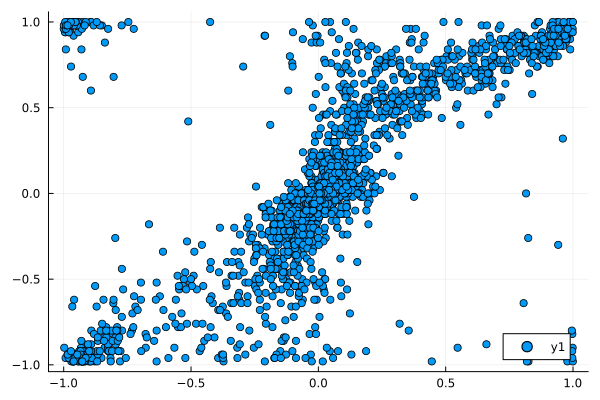

In [66]:
scatter(pc |> vec, dx[3,:,:] |> vec)

In [23]:
dx[:,5,:]

10×10 Matrix{Float64}:
 NaN     -0.08  NaN            NaN     …  NaN      -0.04  NaN
   0.88  -0.16    1.33227e-15  NaN          0.66  NaN       1.33227e-15
   0.84  -0.26    0.02           0.46       0.72   -0.76    0.04
   0.82  -0.5     0.04           0.5        0.68   -0.84    0.1
   0.82  -0.64    0.06           0.48       0.62  NaN       0.1
   0.82  -0.66    0.06           0.46  …    0.56  NaN       0.1
   0.82  -0.68    0.06           0.44       0.54  NaN       0.1
   0.82  -0.68    0.08           0.44       0.54   -0.62    0.1
   0.82  -0.7     0.08           0.42       0.56   -0.68    0.1
   0.82  -0.74    0.08           0.38       0.6    -0.78    0.1

In [24]:
pc[5,:]

10-element Vector{Float32}:
  0.83800006
 -0.08178909
  0.016136035
  0.030195246
  0.022842644
 -0.51608807
 -0.23596652
  0.73017937
 -0.8489816
  0.0604818

In [25]:
function quadrature_loss(phases::AbstractMatrix, truth::AbstractMatrix)
    targets = 0.5 .* truth
    sim = similarity(phases, targets)
    return 1.0 .- sim
end


quadrature_loss (generic function with 1 method)

In [26]:
function accuracy_quadrature(phases::AbstractMatrix, truth::AbstractMatrix)
    predictions = getindex.(argmin(abs.(phases .- 0.5), dims=2), 2)
    labels = getindex.(findall(truth), 1)
    return predictions .== labels
end

accuracy_quadrature (generic function with 1 method)

In [27]:
mean(accuracy_quadrature(pc, y))

0.12109375

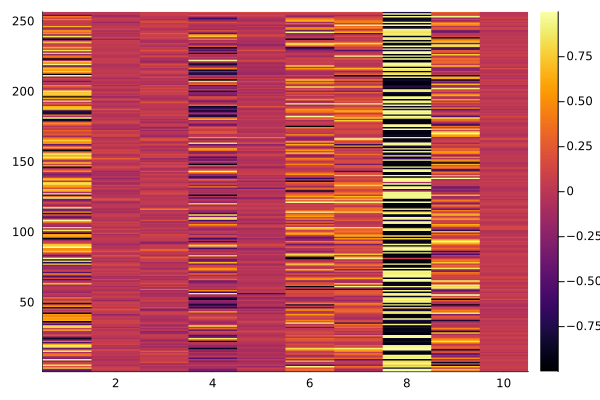

In [28]:
heatmap(pc)

In [29]:
function loss_and_accuracy(data_loader, model)
    acc = 0
    ls = 0.0f0
    num = 0
    for (x, y) in data_loader
        ŷ = model(x')
        
        ls += sum(quadrature_loss(ŷ, y'))
        acc += sum(accuracy_quadrature(ŷ, y)) ## Decode the output of the model
        num +=  size(x)[end]
    end
    return ls / num, acc / num
end

loss_and_accuracy (generic function with 1 method)

In [30]:
loss_and_accuracy(test_loader, phasor_model)

(0.5368397088587927, 0.1099)

In [31]:
using Zygote: withgradient

In [32]:
function train(model; kws...)
    args = Args(; kws...) ## Collect options in a struct for convenience

    # if CUDA.functional() && args.use_cuda
    #     @info "Training on CUDA GPU"
    #     CUDA.allowscalar(false)
    #     device = gpu
    # else
        @info "Training on CPU"
        device = cpu
    # end

    ## Create test and train dataloaders
    train_loader, test_loader = getdata(args)

    @info "Constructing model and starting training"
    ## Construct model
    #model = build_model() |> device

    ## Optimizer
    opt = Flux.setup(Adam(args.η), model)
    losses = []

    ## Training
    for epoch in 1:args.epochs
        for (x, y) in train_loader
            x, y = transpose(device(x)), transpose(device(y)) ## transfer data to device
            loss, gs = withgradient(m -> mean(quadrature_loss(m(x), y)), model) ## compute gradient of the loss
            append!(losses, loss)
            Flux.Optimise.update!(opt, model, gs[1]) ## update parameters
        end

        ## Report on train and test
        train_loss, train_acc = loss_and_accuracy(train_loader, model)
        test_loss, test_acc = loss_and_accuracy(test_loader, model)
        println("Epoch=$epoch")
        println("  train_loss = $train_loss, train_accuracy = $train_acc")
        println("  test_loss = $test_loss, test_accuracy = $test_acc")
    end

    return losses
end

train (generic function with 1 method)

In [33]:
opt = Flux.setup(Adam(3e-4), phasor_model)

(layers = ((weight = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], ComplexF32[0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; … ; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im; 0.0+0.0im 0.0+0.0im … 0.0+0.0im 0.0+0.0im], (0.9, 0.999))), bias = Leaf(Adam{Float64}(0.0003, (0.9, 0.999), 1.0e-8), (ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], ComplexF32[0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im  …  0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im, 0.0+0.0im], (0.9, 0.

In [34]:
l = train(phasor_model)

[ Info: Training on CPU
[ Info: Getting and transforming data
[ Info: Constructing model and starting training


Epoch=1
  train_loss = 0.05689478214331081, train_accuracy = 0.7497833333333334
  test_loss = 0.05615693854418595, test_accuracy = 0.7615
Epoch=2
  train_loss = 0.038526374073379825, train_accuracy = 0.85475
  test_loss = 0.03739621839736299, test_accuracy = 0.8654
Epoch=3
  train_loss = 0.031292261136218594, train_accuracy = 0.8833333333333333
  test_loss = 0.03020769760346103, test_accuracy = 0.8891
Epoch=4
  train_loss = 0.0254099817858826, train_accuracy = 0.90455
  test_loss = 0.0246627797522061, test_accuracy = 0.9101
Epoch=5
  train_loss = 0.022339026334446784, train_accuracy = 0.91595
  test_loss = 0.021787035924424134, test_accuracy = 0.9199
Epoch=6
  train_loss = 0.020564681322956448, train_accuracy = 0.9233
  test_loss = 0.0201870240808422, test_accuracy = 0.9289
Epoch=7
  train_loss = 0.01954807536323443, train_accuracy = 0.9277333333333333
  test_loss = 0.019203953494807375, test_accuracy = 0.9302
Epoch=8
  train_loss = 0.019968899591175857, train_accuracy = 0.929716666666

2350-element Vector{Any}:
 0.5349263986074009
 0.4699283263557684
 0.4393717535947903
 0.3882324848855589
 0.3566565045637984
 0.326466462622776
 0.32054461293466785
 0.30071954090627223
 0.27959164443897694
 0.2665488522125842
 0.25369159846136535
 0.24253709570737794
 0.2361075050127247
 ⋮
 0.020351848463708175
 0.017046956488907757
 0.01701327937881076
 0.0213711487181235
 0.01413818567326166
 0.015530625340980911
 0.018166322400759015
 0.01775605794292305
 0.0180082716448391
 0.01707154446015014
 0.012822260491758369
 0.014215437722618058

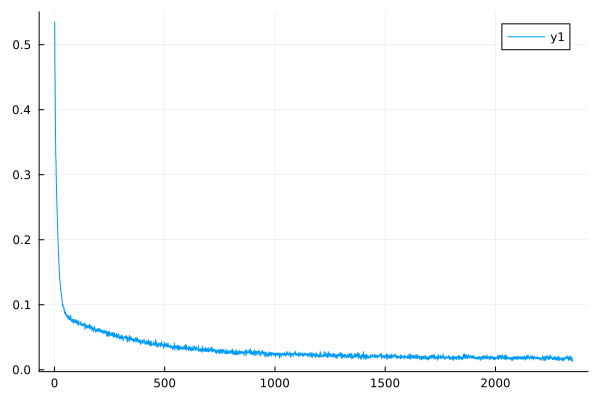

In [35]:
plot(l)

In [36]:
pc2 = phasor_model(x')

256×10 Matrix{Float32}:
 -5.51348f-5   -0.0401136     0.0143807   …   0.0059638     0.0193329
  0.000402273   0.0060573     0.0266925      -0.0186418     0.518631
  0.491699      0.0109339     0.0607934      -0.0146548    -0.0396325
  0.0109178    -0.0051986     0.0312854       0.00412605    0.532736
  0.0228193     0.0205925     0.0293648       0.577829     -0.0207106
  0.00562822   -0.00476108    0.0225947   …  -0.00416064    0.421087
 -0.0176326     0.0998141     0.0318936      -0.00315258    0.0407327
 -0.00983933   -0.0111272     0.0124622       0.0197915     0.0894205
  0.594786     -0.00649514    0.00293942     -0.0284511    -0.0174012
  0.00238556   -0.0331825     0.0176357      -0.0268359    -0.00966533
 -0.0136275     0.0160421     0.0125073   …  -0.009006      0.03073
  0.00147113    0.00392305    0.122468        0.000992503  -0.0342003
  0.0478635     0.00201663    0.0319338       0.534979      0.025037
  ⋮                                       ⋱                
 -0.0327939

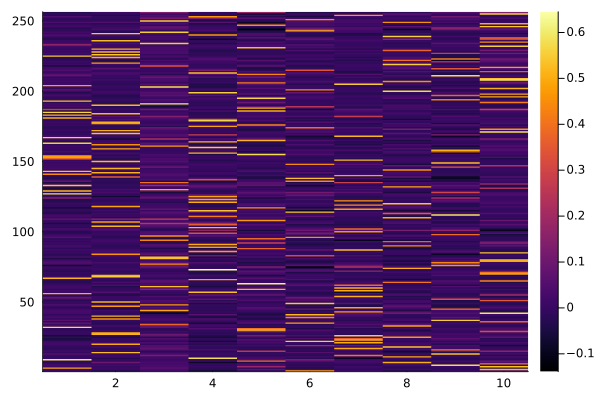

In [37]:
heatmap(pc2)

In [38]:
pc2 |> size

(256, 10)

In [39]:
pc2[1, :]

10-element Vector{Float32}:
 -5.513477f-5
 -0.04011356
  0.014380653
 -0.06964709
 -0.018674653
  0.47746116
  0.004986205
 -0.044892456
  0.005963802
  0.01933292

In [40]:
y1 = phasor_model[1](x')

256×32 Matrix{Float32}:
  0.595043    0.788265   0.288828   …   0.976111  -0.973611  -0.149201
  0.113063    0.846495   0.634442       0.949544  -0.948151  -0.32627
  0.529355    0.850715  -0.185999      -0.563394  -0.338774  -0.277575
 -0.00911952  0.906432   0.768783       0.927402  -0.93582   -0.245538
  0.664852    0.750922   0.392659      -0.985806  -0.906162  -0.177269
 -0.0333029   0.908891   0.618326   …   0.859967  -0.885182  -0.330693
  0.0875863   0.891048   0.235197      -0.957235  -0.960506  -0.266387
  0.127805    0.896749   0.732993       0.869714  -0.830877  -0.480166
  0.583279    0.802253   0.116317      -0.57711   -0.176607  -0.261084
  0.0684002   0.799467   0.39201       -0.918823   0.947795  -0.497433
  0.171972    0.902533   0.426119   …  -0.883443  -0.915696  -0.151591
  0.719433    0.976543   0.0239697      0.906878  -0.98419   -0.743314
  0.440198    0.781965   0.215417      -0.979625  -0.914274  -0.210997
  ⋮                                 ⋱              ⋮  

In [41]:
y1_spk = phasor_model[1](call)

SpikingCall(Spike Train: (256, Base.OneTo(32)) with 77814 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [42]:
y_spk = phasor_model(call)

SpikingCall(Spike Train: (256, Base.OneTo(10)) with 24966 spikes., Neuron parameters: Period 1.0 (s)
Current kernel duration: 0.03 (s)
Threshold: 0.02 (V)
, (0.0, 10.0))

In [43]:
y1p = train_to_phase(y1_spk)

10×256×32 Array{Float64, 3}:
[:, :, 1] =
 NaN     -0.22  NaN     -0.12  NaN     …  -0.24  NaN     NaN     -0.12  -0.14
  -0.82  -0.44   -0.7   -0.2    -0.8      -0.38   -0.56   -0.94  -0.16  -0.16
  -0.88  -0.52   -0.74  -0.24   -0.84     -0.44   -0.62   -0.96  -0.16  -0.16
  -0.9   -0.56   -0.74  -0.24   -0.84     -0.4    -0.64   -0.96  -0.12  -0.1
  -0.9   -0.56   -0.74  -0.24   -0.84     -0.4    -0.64   -0.96  -0.12  -0.1
  -0.9   -0.56   -0.76  -0.24   -0.84  …  -0.4    -0.64   -0.96  -0.12  -0.12
  -0.9   -0.56   -0.76  -0.24   -0.86     -0.4    -0.64   -0.96  -0.12  -0.12
  -0.9   -0.56   -0.76  -0.26   -0.86     -0.4    -0.64   -0.96  -0.12  -0.12
  -0.9   -0.56   -0.76  -0.26   -0.86     -0.4    -0.64   -0.96  -0.12  -0.12
  -0.9   -0.56   -0.76  -0.26   -0.86     -0.42   -0.64   -0.96  -0.12  -0.12

[:, :, 2] =
 NaN     NaN     NaN     NaN     NaN     …  NaN     NaN     NaN    NaN
  -0.82   -0.9    -0.88   -0.88   -0.72      -0.9    -0.9    -0.9   -0.8
  -0.84   -0.92   -0.88 

In [44]:
yp = train_to_phase(y_spk)

10×256×10 Array{Float64, 3}:
[:, :, 1] =
 NaN     NaN           NaN     NaN     …  NaN     NaN     NaN
   0.2     0.08        NaN       0.06       0.02   -0.02    0.06
  -0.04   -3.9968e-14   -0.88    0.02      -0.02   -0.02    0.04
  -0.1    -0.02         -0.9     0.02      -0.04   -0.04   -8.26006e-14
  -0.16   -0.04         -0.92    0.02      -0.06   -0.06   -0.02
  -0.26   -0.06         -0.94    0.02  …   -0.08   -0.06   -0.02
  -0.3    -0.06         -0.94    0.02      -0.08   -0.06   -0.02
  -0.22   -0.06         -0.96    0.02      -0.1    -0.06   -0.04
  -0.14   -0.06         -0.96    0.02      -0.1    -0.08   -0.04
  -0.1    -0.06         -0.96    0.02      -0.1    -0.08   -0.04

[:, :, 2] =
 -0.04        -0.12  -0.08  -0.12  …  -0.08  -0.02  NaN     -0.1   -0.02
 -0.02        -0.12  -0.08  -0.16     -0.08  -0.06   -0.04  -0.12  -0.08
 -3.9968e-14  -0.2   -0.08  -0.16     -0.06  -0.06   -0.08  -0.14  -0.1
 -0.04        -0.24  -0.08  -0.18     -0.06  -0.1    -0.08  -0.16  -0.1
 -

In [57]:
function cor_realvals(x, y)
    is_real = x -> .!isnan.(x)
    x_real = is_real(x)
    y_real = is_real(y)
    reals = x_real .* y_real
    
    cor_val = cor(x[reals], y[reals])
    return cor_val
end


cor_realvals (generic function with 1 method)

In [62]:
function cycle_correlation(static_phases::Matrix{<:Real}, dynamic_phases::Array{<:Real,3})
    n_cycles = axes(dynamic_phases, 1)
    cor_vals = [cor_realvals(static_phases |> vec, dynamic_phases[i,:,:] |> vec) for i in n_cycles]
    return cor_vals
end

cycle_correlation (generic function with 1 method)

In [63]:
cycle_correlation(y1, y1p)

10-element Vector{Float64}:
 -0.9276720988586492
 -0.7248187412841979
 -0.6914076106351488
 -0.7013842658594359
 -0.6982345821502463
 -0.696009110719227
 -0.6929281951378089
 -0.6901851205146134
 -0.6854703827709873
 -0.6814745370920259

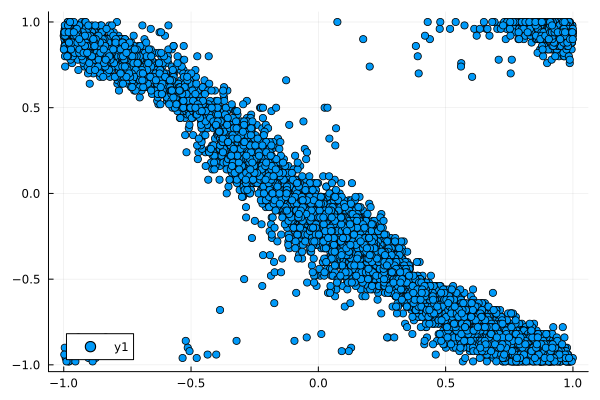

In [45]:
scatter(vec(y1), vec(y1p[3,:,:]))

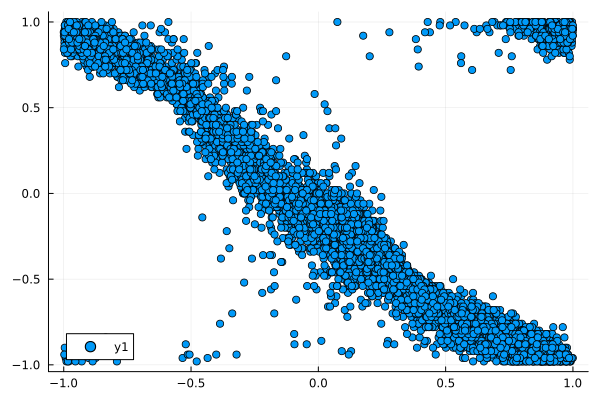

In [46]:
scatter(vec(y1), vec(y1p[4,:,:]))

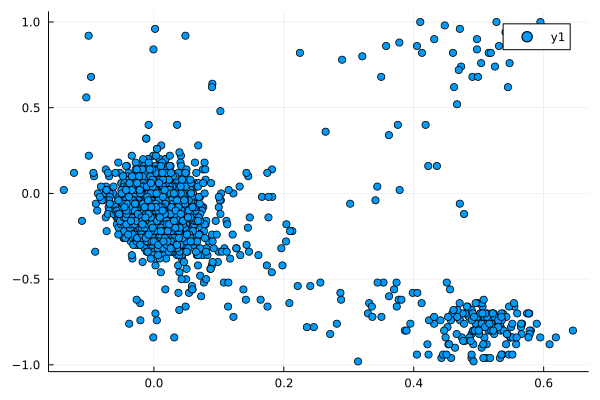

In [47]:
scatter(vec(pc2), vec(yp[3,:,:]))

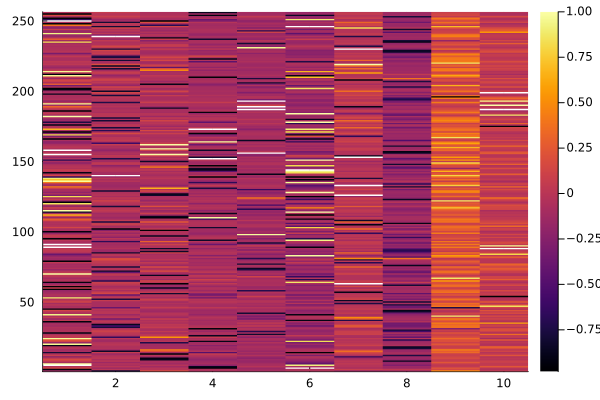

In [52]:
heatmap(yp[5,:,:])

In [54]:
y[:,1]

10-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 1
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅

In [49]:
yp[4,1,:]

10-element Vector{Float64}:
 -0.12000000000008004
 -0.8200000000000651
  0.11999999999995747
 -0.06000000000008132
 -0.0800000000000809
 -0.06000000000008132
  0.3399999999999528
 -0.14000000000007962
  0.43999999999995065
  0.03999999999995918

In [45]:
y[:,1]

10-element OneHotVector(::UInt32) with eltype Bool:
 ⋅
 ⋅
 1
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅
 ⋅

In [50]:
loss_and_accuracy(test_loader, phasor_model)

(0.016165774741772377, 0.9373)